## Title: Predict (past/retired) player earnings based on their historical performance compared to 2022-2023 season 

###  Predictive Question

What would be a past/retired NBA player’s present-day earnings according to their historical stats: age, games played, total minutes played, total shooting percentage?

### Introduction:
The National Basketball Association (NBA) is a North American professional basketball league consisting of 2 conferences. Each conference has 3 divisions, and each division has 5 teams. The NBA is one of the major professional sports leagues in the United States and Canada. It is regarded as the highest level men's professional basketball tournament in the world. We are going to use a dataset from "basketball-reference.com", which provides precise statistics for all players. In this project, we are going to investigate the relationship between the players' salary and the following variables during the 2022-23 season: 
* Position
* Age = age pf players
* GP = number of games played
* GS = number of games started 
* Total Minutes = total minutes played
* PTS = points
* eFG% = effective field goal percentage
* TS% = true shooting percentage
* WS = win shares
* VORP = value over replacement player

### Preliminary exploratory data analysis:

In [1]:
library(tidyverse)
library(repr)
library(tidymodels)
install.packages("kknn")
install.packages("gridExtra")
library(kknn)
library(gridExtra)
options(repr.matrix.max.rows = 6)
source("tests.R")
source('cleanup.R')

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.2 ──
✔ ggplot2 3.4.2     ✔ purrr   1.0.1
✔ tibble  3.2.1     ✔ dplyr   1.1.1
✔ tidyr   1.3.0     ✔ stringr 1.5.0
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.2     ✔ rsample      1.1.1
✔ dials        1.1.0     ✔ tune         1.0.1
✔ infer        1.0.4     ✔ workflows    1.1.2
✔ modeldata    1.0.1     ✔ workflowsets 1.0.0
✔ parsnip      1.0.3     ✔ yardstick    1.1.0
✔ recipes      1.0.4     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks read

ERROR: Error in file(filename, "r", encoding = encoding): cannot open the connection


### Read the dataset using a relative path：

In [28]:
nba <- read_csv("nba_2022-23.csv")
nba

New names:
• `` -> `...1`
Rows: 467 Columns: 52
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (3): Player Name, Position, Team
dbl (49): ...1, Salary, Age, GP, GS, MP, FG, FGA, FG%, 3P, 3PA, 3P%, 2P, 2PA...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


...1,Player Name,Salary,Position,Age,Team,GP,GS,MP,FG,⋯,TOV%,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP
<dbl>,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,Stephen Curry,48070014,PG,34,GSW,56,56,34.7,10.0,⋯,12.5,31.0,5.8,2.0,7.8,0.192,7.5,0.1,7.5,4.7
1,John Wall,47345760,PG,32,LAC,34,3,22.2,4.1,⋯,17.1,27.0,-0.4,0.7,0.3,0.020,-0.8,-0.4,-1.2,0.1
2,Russell Westbrook,47080179,PG,34,LAL/LAC,73,24,29.1,5.9,⋯,18.4,27.7,-0.6,2.6,1.9,0.044,0.3,-0.1,0.2,1.2
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋱,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
464,Gabe York,32171,SG,29,IND,3,0,18.7,2.7,⋯,0.0,16.4,0.1,0.0,0.1,0.091,-1.7,-1.8,-3.5,0
465,RaiQuan Gray,5849,PF,23,BRK,1,0,35.0,6.0,⋯,23.7,21.4,0.0,0.0,0.1,0.106,-0.6,-1.4,-2.0,0
466,Jacob Gilyard,5849,PG,24,MEM,1,0,41.0,1.0,⋯,40.0,5.1,0.0,0.1,0.1,0.079,-7.8,1.7,-6.1,0


### Wrangling data:
Since the data has large number of variables, we selected variabels which might be useful for the analysis 
to simplify our data.

In [29]:
nba_selected <- nba |>
select("Player Name", Salary, Position, Age, GP, GS, "Total Minutes", PTS, "eFG%", "TS%", WS, VORP) |>
rename(total_minutes = "Total Minutes") |>
rename(TSP = "TS%") |>
rename(eFGP = "eFG%") 
nba_selected

Player Name,Salary,Position,Age,GP,GS,total_minutes,PTS,eFGP,TSP,WS,VORP
<chr>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Stephen Curry,48070014,PG,34,56,56,1941,29.4,0.614,0.656,7.8,4.7
John Wall,47345760,PG,32,34,3,755,11.4,0.457,0.498,0.3,0.1
Russell Westbrook,47080179,PG,34,73,24,2126,15.9,0.481,0.513,1.9,1.2
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
Gabe York,32171,SG,29,3,0,56,8,0.524,0.548,0.1,0
RaiQuan Gray,5849,PF,23,1,0,35,16,0.583,0.621,0.1,0
Jacob Gilyard,5849,PG,24,1,0,41,3,0.500,0.500,0.1,0


In [30]:
nba_filtered <- nba_selected |>
                   filter(abs(Salary - mean(Salary)) < 2 * sd(Salary)) |>
                   select(Salary, Age, GP, TSP, total_minutes)|>
                   drop_na()

nba_filtered

Salary,Age,GP,TSP,total_minutes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
29776785,26,67,0.581,2405
28400000,37,59,0.555,1889
28333334,36,55,0.565,1718
⋮,⋮,⋮,⋮,⋮
32171,29,3,0.548,56
5849,23,1,0.621,35
5849,24,1,0.500,41


### Summary of the dataset:

In [31]:
summarize(nba_filtered,
          "Number of observations" = nrow(nba_filtered),
          "Rows with missing data" = sum(is.na(nba_filtered)))

results_salary <- nba_filtered |>
    summarize(variable = "Salary", max = max(Salary),min = min(Salary),mean = formatC(mean(Salary),digits=8)) 
results_age <- nba_filtered |>
    summarize(variable = "Age", max = max(Age),min = min(Age),mean = formatC(mean(`Age`),digits=4) )
results_GP <- nba_filtered |>
    summarize(variable = "GP", max = max(GP),min = min(GP),mean = formatC(mean(`GP`),digits=4)) 
results_mins <- nba_filtered |>
    summarize(variable = "Mins", max = max(total_minutes),min = min(total_minutes),mean = formatC(mean(total_minutes),digits=4)) 
results_TSP <- nba_filtered |>
    summarize(variable = "TSP", max = max(TSP),min = min(TSP),mean = formatC(mean(`TSP`),digits=4)) 

Summary_results <- rbind(results_salary,results_age,results_GP,results_mins,results_TSP)
Summary_results

Number of observations,Rows with missing data
<int>,<int>
425,0


variable,max,min,mean
<chr>,<dbl>,<dbl>,<chr>
Salary,29776785.000,5849,5705617.6
Age,42.000,19,25.5
GP,83.000,1,47.33
Mins,2963.000,2,1032
TSP,1.064,0,0.5598


### Visualization of dataset:

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


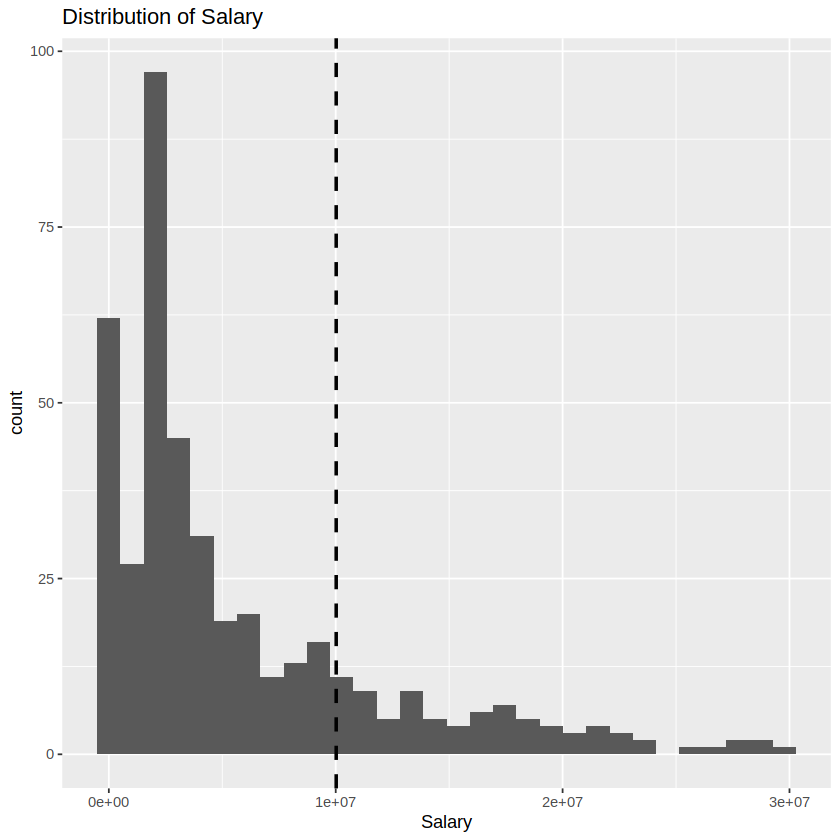

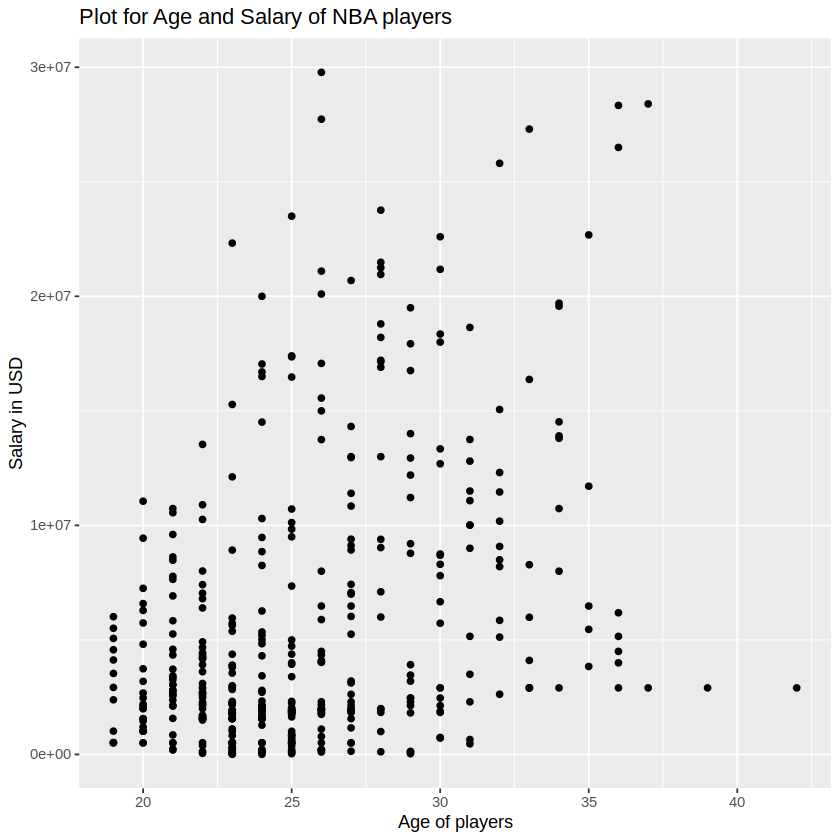

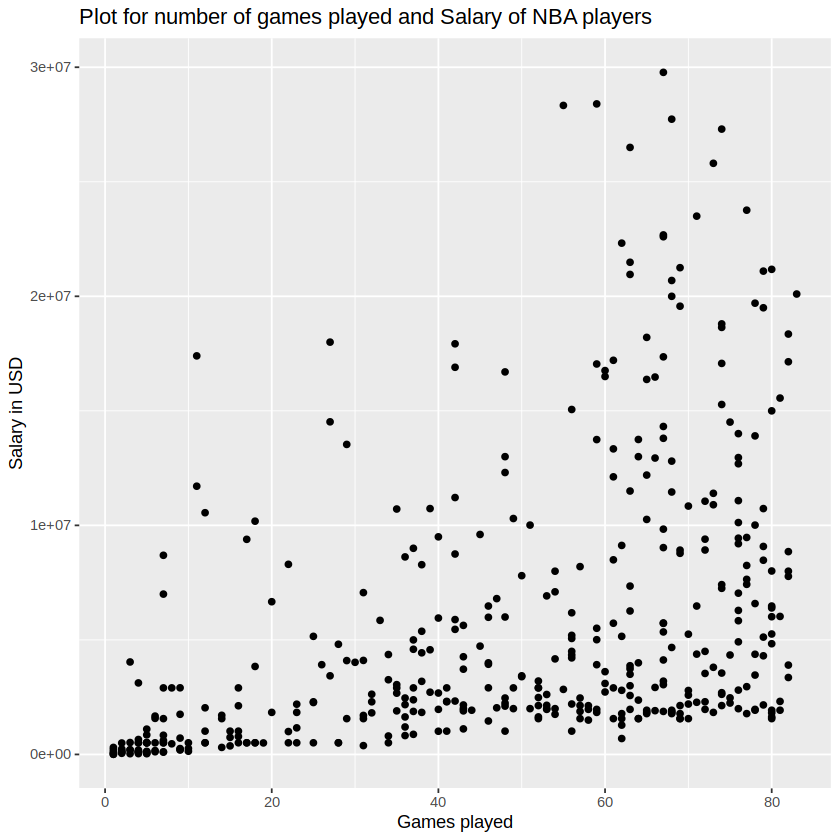

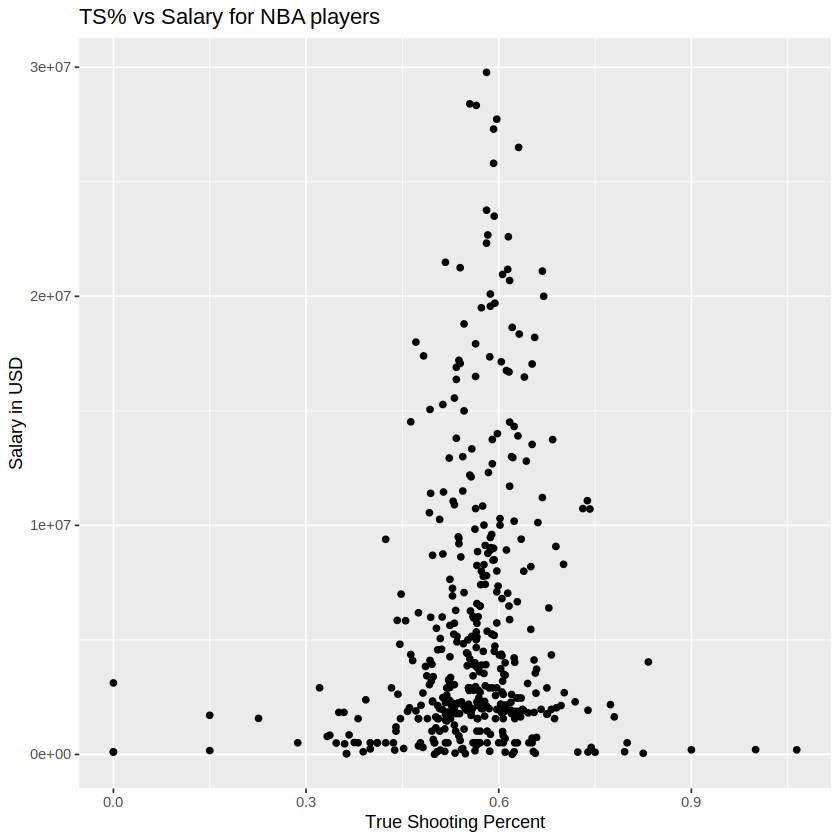

In [32]:
nba_salary_hist<- ggplot(nba_filtered, aes(x=Salary))+
                geom_histogram()+
                labs(x="Salary", title = "Distribution of Salary")+
                geom_vline(xintercept = 10021090, linetype = "dashed", linewidth = 1)

nba_salary_age_plot <- ggplot(nba_filtered, aes(x=Age, y=Salary))+
                        geom_point()+
                        labs(x="Age of players",y="Salary in USD",title="Plot for Age and Salary of NBA players")
    
 
nba_salary_GP_plot <- ggplot(nba_filtered, aes(x=GP, y=Salary))+
                        geom_point()+
                        labs(x="Games played",y="Salary in USD",title="Plot for number of games played and Salary of NBA players")

nba_salary_TSP_plot <- ggplot(nba_filtered, aes(x=TSP, y=Salary))+
                        geom_point()+
                        labs(x="True Shooting Percent",y="Salary in USD",title="TS% vs Salary for NBA players")

nba_salary_hist
nba_salary_age_plot
nba_salary_GP_plot
nba_salary_TSP_plot

#Histogram to visualize the distrbution of salary for nba players in 2022/23 season
#Added a vline at where the mean salary lies

#Scatterplot is to show the correlation between age and salary 

### Perform analysis:

In [33]:
set.seed(1)
nba_split <- initial_split(nba_filtered, prop = 0.8, strata = Salary)
nba_training <- training(nba_split) #training data
nba_testing <- testing(nba_split) #testing data

In [34]:
nba_recipe <- recipe(Salary ~., data = nba_training) #create recipe to preprocess data

nba_spec <- linear_reg()|> #model specification
set_engine("lm") |>
set_mode("regression")

In [35]:
nba_fit <- workflow() |> #build the workflow and fit the model
add_recipe(nba_recipe) |>
add_model(nba_spec) |>
fit(data = nba_training)
nba_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: linear_reg()

── Preprocessor ────────────────────────────────────────────────────────────────
0 Recipe Steps

── Model ───────────────────────────────────────────────────────────────────────

Call:
stats::lm(formula = ..y ~ ., data = data)

Coefficients:
  (Intercept)            Age             GP            TSP  total_minutes  
    -10778118         528004         -92459        -379557           7226  


In [36]:
nba_test_result <- nba_fit |> 
  predict(nba_testing) |>
  bind_cols(nba_testing)
nba_test_result

.pred,Salary,Age,GP,TSP,total_minutes
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
16053979,26500000,36,63,0.631,1922
15741927,25806468,32,73,0.592,2297
16443692,23760000,28,77,0.581,2737
⋮,⋮,⋮,⋮,⋮,⋮
-88655.25,193027,21,9,0.438,83
1791633.67,160856,24,2,0.563,41
1086040.94,58493,23,1,0.532,2


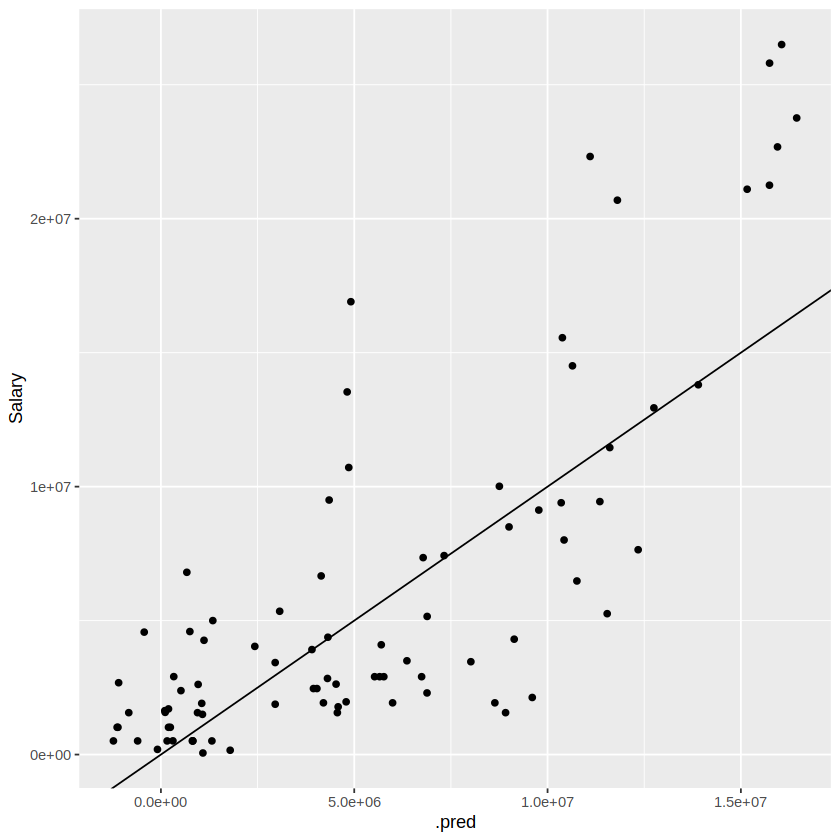

In [37]:
nba_test_results_plot <- ggplot(nba_test_result, aes(x=.pred,y=Salary)) +
                               geom_point()+
                                geom_abline(slope=1,intercept=0)

nba_test_results_plot

### Methods:
In the 2022-2023 season dataset, the following variables will be selected: 

    -Age: Often indicates a player's experience and professional maturity 

    -Games Played: Evidences a player's reliability 

    -Total Minutes Played: Indicates a player's significance to the team 

    -True Shooting Percent: Measures a player's ability to score efficiently 

The selection of these variables rests on the hypothesis that they determine a player's worth and, consequently, their salary. Observations with missing data will be removed. 

Scatterplots will illustrate the relationship between each variable and the player's salary, aiding in the visualization of potential correlations. If any variable shows weak correlation, it will be replaced. The main modeling technique will be multiple regression, with cross-validation ensuring model robustness. Finally, this model will aid in estimating a retired player's current earnings based on their past performances. 

 

### Expected Outcomes:

Our model aims to find the expected salary of a past NBA player if they were to play in 2023. We expect all four variables listed in our methods section to correlate positively with salary by assuming that higher skill equates to higher salary. The only non-skill variable is age, which we expect to positively correlate since older players are more experienced. However, we expect there to be a peak earning age, athleticism often decreases with age. 

Considering these variables, we expect that the past NBA player would be paid less in 2023 than the current NBA players. This is due to the general increase in skill across all competitive sports over time; the longer a sport is played, the better the skills it requires are understood.  

### Impact:
The findings of this data model would be significant to the training of professional basketball players. Coaches are able to analyze changes in each variable to determine whether there has been positive improvement in the sport and can apply the relevant changes to their training methods.  

### Future questions:
Does the team the player is on have an impact on their salary?  
Do certain training methods yield higher salaries on average? 
How significant is the impact of player injuries on salary?